### This CNN is modeled on LeNet-5, with two conv-pool blocks, only 8 and 16 filters in those conv layers, and 3 fully connected layers at the end.

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
import os
root_logdir = os.path.join(os.curdir, "lenet_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [11]:
batch_size = 32
target_size = (180,180)

train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.1)


train_generator = train_datagen.flow_from_directory('../data/images/train',
                                                    color_mode='rgb',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory('../data/images/train',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical',
                                                       subset='validation')

holdout_generator = test_datagen.flow_from_directory('../data/images/holdout',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical')

labels = (train_generator.class_indices)
labels = dict((v, k) for k,v in labels.items())
labels


Found 2051 images belonging to 6 classes.
Found 225 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [12]:
model = Sequential()
model.add(InputLayer(input_shape=(target_size[0], target_size[1], 3)))

model.add(Conv2D(8, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(16, 5, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(6, activation='softmax'))


opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 180, 180, 8)       224       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 16)        3216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32400)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               3888120   
_________________________________________________________________
dense_10 (Dense)             (None, 84)               

In [13]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('lenet.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())


history = model.fit(
    train_generator,
    validation_data = validation_generator, 
    verbose=1,
    epochs = 50,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/50
65/65 [==============================] - 43s 659ms/step - loss: 2.2921 - accuracy: 0.2309 - val_loss: 1.5746 - val_accuracy: 0.2978
Epoch 2/50
65/65 [==============================] - 41s 635ms/step - loss: 1.5165 - accuracy: 0.3727 - val_loss: 1.3984 - val_accuracy: 0.3644
Epoch 3/50
65/65 [==============================] - 42s 651ms/step - loss: 1.3701 - accuracy: 0.4467 - val_loss: 1.3720 - val_accuracy: 0.4311
Epoch 4/50
65/65 [==============================] - 40s 616ms/step - loss: 1.2626 - accuracy: 0.4921 - val_loss: 1.2897 - val_accuracy: 0.5022
Epoch 5/50
65/65 [==============================] - 40s 618ms/step - loss: 1.2282 - accuracy: 0.5430 - val_loss: 1.1984 - val_accuracy: 0.5378
Epoch 6/50
65/65 [==============================] - 41s 628ms/step - loss: 1.1641 - accuracy: 0.5570 - val_loss: 1.2569 - val_accuracy: 0.5022
Epoch 7/50
65/65 [==============================] - 41s 636ms/step - loss: 1.0784 - accuracy: 0.5944 - val_loss: 1.1075 - val_accuracy: 0.5422

In [14]:
score = model.evaluate(holdout_generator, verbose=0)
print('Holdout accuracy:', score[1])

Holdout accuracy: 0.7529880404472351


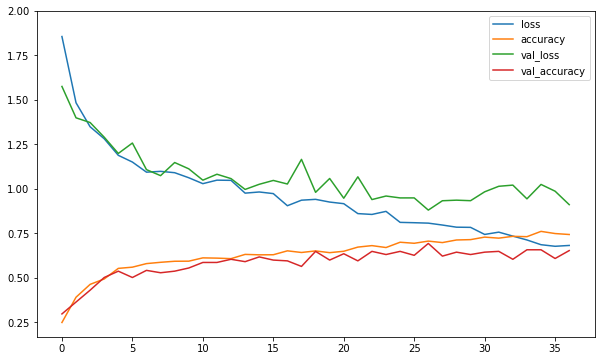

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
[plt.plot(history.history[i], label=i) for i in history.history.keys()]
plt.ylim(top=2)
plt.legend();

In [20]:
max(history.history['val_accuracy'])

0.6933333277702332